In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
sequences_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/evidence-6-oct.txt', sep='\\t', engine='python')

In [3]:
# remove decoys, which are indicated by a '+' in the Reverse column, and features with no intensity
sequences_df = sequences_df[pd.isna(sequences_df.Reverse) & (sequences_df.Intensity > 0) & pd.notnull(sequences_df['Modified sequence'])]

In [4]:
sequences_df.columns

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Type',
       'Raw file', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'Calibrated CCS', 'CCS length', 'Match time difference',
       'Match m/z difference', 'Match K0 difference', 'Match q-value',
       'M

In [5]:
sequences_df[['Sequence','Modifications','Modified sequence']].sample(n=10)

,Sequence,Modifications,Modified sequence
172066,FLSAPEAVEYGLVDSILTHR,Unmodified,_FLSAPEAVEYGLVDSILTHR_
490109,SGDAAIVDMVPGKPMCVESFSDYPPLGR,Unmodified,_SGDAAIVDMVPGKPMCVESFSDYPPLGR_
273213,IMYTVFEHTFHVR,Unmodified,_IMYTVFEHTFHVR_
344794,LLVVYPWTQR,Unmodified,_LLVVYPWTQR_
327215,LGTQEYLQQLESHMK,Unmodified,_LGTQEYLQQLESHMK_
486015,SEGTYLNSVIESHTEFIFTTIK,Unmodified,_SEGTYLNSVIESHTEFIFTTIK_
575575,VDSDDQWGEYSCVFLPEPMGTANIQLHGPPR,Unmodified,_VDSDDQWGEYSCVFLPEPMGTANIQLHGPPR_
401614,NAELDPVTTEEQVLDVK,Unmodified,_NAELDPVTTEEQVLDVK_
409591,NGLSPIHMAAQGDHLDCVR,Unmodified,_NGLSPIHMAAQGDHLDCVR_
447527,PYFLTDGTGTVTPANASGINDGAAAVVLMK,Unmodified,_PYFLTDGTGTVTPANASGINDGAAAVVLMK_


In [6]:
sequences_df.Modifications.unique()

array(['Unmodified', 'Acetyl (Protein N-term)', 'Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', '2 Oxidation (M)',
       'Acetyl (Protein N-term),2 Oxidation (M)'], dtype=object)

In [7]:
sequences_df[sequences_df['Modified sequence'] == '']

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins,...,Reverse,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Taxonomy IDs


In [8]:
sequences_df['Type'].unique()

array(['TIMS-MULTI-MSMS'], dtype=object)

In [9]:
len(sequences_df.drop_duplicates(subset=['Modified sequence', 'Charge'], keep='first', inplace=False))

31278

In [10]:
sequences_df['group'] = sequences_df['Raw file'].apply(lambda x: x.split('_')[0])

#### analyse the YHE runs

In [11]:
yhe_only_df = sequences_df[(sequences_df.group == 'YHE211') | (sequences_df.group == 'YHE114')]

In [12]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in yhe_only_df.groupby(['Modified sequence','Charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df['Raw file'].unique())))
yhe_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [13]:
number_of_yhe_runs_in_experiment = len(yhe_only_df['Raw file'].unique())
print('there are {} runs in the experiment'.format(number_of_yhe_runs_in_experiment))

there are 21 runs in the experiment


In [14]:
# display the number of missing values across the experiment
yhe_sequence_occurences_df['missing_files'] = number_of_yhe_runs_in_experiment - yhe_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = yhe_sequence_occurences_df.missing_files.sum() / (len(yhe_sequence_occurences_df) * number_of_yhe_runs_in_experiment)
print("{}% of values missing across the YHE runs.".format(round(proportion_of_missing_extractions*100)))

52.0% of values missing across the YHE runs.


In [15]:
modified_sequences_count = len(yhe_only_df['Modified sequence'].unique())
modified_sequences_count

23182

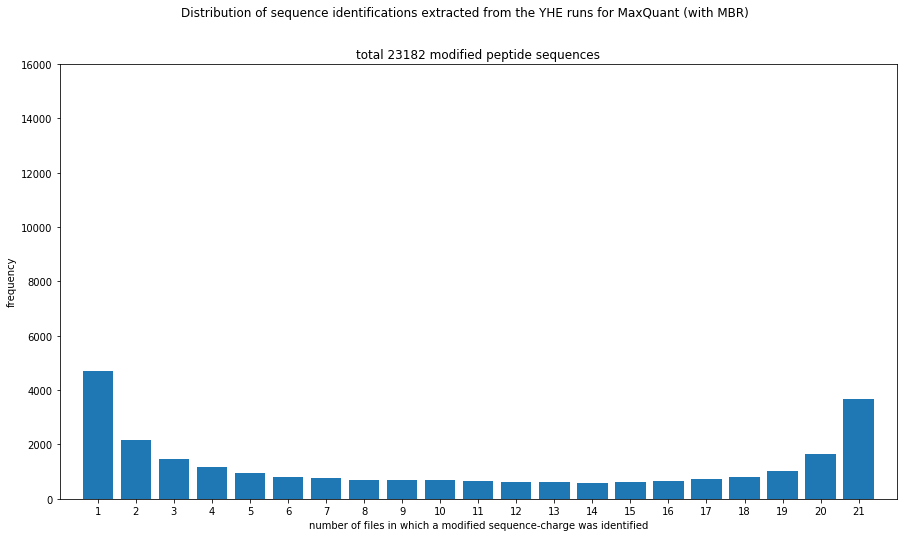

In [16]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications extracted from the YHE runs for MaxQuant (with MBR)')
plt.title('total {} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(yhe_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(22), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was identified')
plt.ylabel('frequency')
ax1.set(xticks=range(1,22), xlim=[0, 22])
plt.ylim((0,16000))

plt.show()

#### analyse the human-only runs

In [17]:
human_only_df = sequences_df[(sequences_df.group == 'YHE010')].copy()

In [18]:
# count how many runs each sequence/charge was extracted from
sequence_occurences_l = []
for group_name,group_df in human_only_df.groupby(['Modified sequence','Charge'], as_index=False):
    sequence_occurences_l.append((group_name[0], group_name[1], len(group_df['Raw file'].unique())))
human_sequence_occurences_df = pd.DataFrame(sequence_occurences_l, columns=['sequence','charge','number_of_runs_extracted'])

In [19]:
number_of_human_runs_in_experiment = len(human_only_df['Raw file'].unique())
print('there are {} human-only runs in the experiment'.format(number_of_human_runs_in_experiment))

there are 10 human-only runs in the experiment


In [20]:
# display the number of missing values across the experiment
human_sequence_occurences_df['missing_files'] = number_of_human_runs_in_experiment - human_sequence_occurences_df.number_of_runs_extracted
proportion_of_missing_extractions = human_sequence_occurences_df.missing_files.sum() / (len(human_sequence_occurences_df) * number_of_human_runs_in_experiment)
print("{}% of values missing across the experiment.".format(round(proportion_of_missing_extractions*100)))

47.0% of values missing across the experiment.


In [21]:
unique_sequences_human_df = human_only_df.drop_duplicates(subset=['Modified sequence', 'Charge'], keep='first', inplace=False).copy()

In [22]:
# how many are not human?
unique_sequences_human_df['human'] = unique_sequences_human_df['Proteins'].str.contains('HUMAN')

In [23]:
unique_sequences_human_df.human.value_counts()

True     19986
False      269
Name: human, dtype: int64

In [24]:
print('false positives: {}%'.format(round(len(unique_sequences_human_df[(unique_sequences_human_df.human == False)]) / len(unique_sequences_human_df) * 100.0, 1)))

false positives: 1.3%


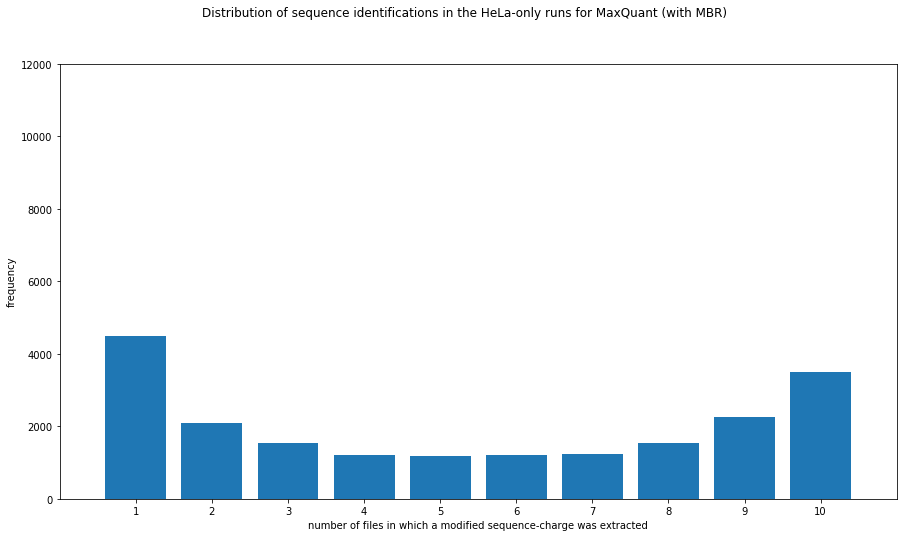

In [26]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.suptitle('Distribution of sequence identifications in the HeLa-only runs for MaxQuant (with MBR)')
# plt.title('total {} modified peptide sequences'.format(modified_sequences_count))

counts = np.bincount(human_sequence_occurences_df.number_of_runs_extracted)
ax1.bar(range(11), counts, width=0.8, align='center')
plt.xlabel('number of files in which a modified sequence-charge was extracted')
plt.ylabel('frequency')
ax1.set(xticks=range(1,11), xlim=[0, 11])
plt.ylim((0,12000))

plt.show()